In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
params = {
    'total': 10,
    'groups': 2,
    'labels': ['Frauen','Männer'],
    'colors': ['pink','teal'],
    'minOffset': -20, 
    'maxOffset': 22,
    'offsetSteps': 10,
    'clusters': 10,
    'clusters_offset': 10,
    'question_offset': 1350,
}

qualifications = [
    [76],
    [86,67],
    [91,76,65],
    [94,80,72,63],
    [96,83,76,69,62],
    [98,86,79,73,68,61],
    [100,87,81,76,71,67,60],
    [100,89,83,78,74,70,66,60],
    [100,91,84,80,76,72,69,65,59],
    [100,92,86,81,77,74,71,68,64,59]
    ]

In [3]:
def generate_question(ratio, maj, questionNo, qualOffset, positions):
    placement = [1,1,1,1,1,1,1,1,1,1]
    for n in positions:
        if (n >= 0): placement[n] = 0

    question = {
        'personas': [],
        'questionType': 'ranking',
        'groupNames': [],
        'colors': [],
        'number': questionNo,
        'minSize': ratio,
        'majSize': params['total'] - ratio,
        'offset': qualOffset,
    }

    question['groupNames'].append(params['labels'][maj])
    question['groupNames'].append(params['labels'][(maj+1)%2])
    question['colors'].append(params['colors'][maj])
    question['colors'].append(params['colors'][(maj+1)%2])
    if(maj): question['majLabel'] = 'female'
    else: question['majLabel'] = 'male'

    # add personas
    p_min = 0
    p_maj = 0
    
    min_utility = 100
    max_utility = 50
    ordering_utility = 0
    
    for p in range(params['total']):
        persona = {
            'group': placement[p],
            'number': p,
        }
        
        # minority qualification with offset
        if (not placement[p]):
            persona['qualification'] = max(min(qualifications[ratio - 1][p_min] + qualOffset, 100), 50)
            p_min += 1
        else:
            persona['qualification'] = qualifications[params['total'] - ratio - 1][p_maj]
            p_maj += 1
            
        question['personas'].append(persona)
    
        # (ranked) ordering utility by Zehlike et al.
        delta = min_utility - persona['qualification']
        ordering_utility = min(ordering_utility, delta) # assures min_utility < persona['qualification']
        min_utility = min(min_utility, persona['qualification'])
        max_utility = max(max_utility, persona['qualification'])
    
    # normalized ordering utility
    question['ordering_utility'] = 1 - ordering_utility / (min_utility - max_utility)
    
    # accuracy as sum of differences
    q_sorted = question['personas'].copy()
    q_sorted.sort(key=lambda persona: persona['qualification'], reverse=True)
    q_reverse = question['personas'].copy()
    q_reverse.sort(key=lambda persona: persona['qualification'], reverse=False)
    sum_of_diff = 0
    worst_case = 0
    for i in range(len(question['personas'])):
        sum_of_diff += abs(question['personas'][i]['qualification'] - q_sorted[i]['qualification'])
        worst_case += abs(q_reverse[i]['qualification'] - q_sorted[i]['qualification'])
    question['sum_of_diff'] = 1 - sum_of_diff / worst_case
    
    #rND score
    rnd = 0
    sum_min = 0
    for i in range(1, params['total']):
        if (not placement[i]): sum_min += 1
        rnd += 1/np.log2(i+1)*(sum_min/i-ratio/params['total'])
    
    worst_placement = [] + [0]*ratio + [1]*(params['total'] - ratio)
    worst_rnd = 0
    sum_min = 0
    for i in range(1, params['total']):
        if (not worst_placement[i-1]): sum_min += 1
        worst_rnd += 1/np.log2(i+1)*(sum_min/i-ratio/params['total'])
    
    worst_placement2 = [] + [0]*ratio + [1]*(params['total'] - ratio)
    worst_rnd2 = 0
    sum_min = 0
    for i in range(1, params['total']):
        if (not worst_placement2[i-1]): sum_min += 1
        worst_rnd2 += 1/np.log2(i+1)*(sum_min/i-ratio/params['total'])
        
    question['rND'] = 1 - rnd/abs(worst_rnd)
    question['raw_rND'] = rnd
    question['worst_rND'] = worst_rnd

    return question



questions = []
questionNo = params['question_offset']

# all groups get to be majority
for maj in range(params['groups']):
    # all ratios from 1:9 to 5:5
    for ratio in range(1, int(params['total']//2) + 1):
        # qualification offsets for minority
        for qualOffset in range(params['minOffset'], params['maxOffset'], params['offsetSteps']):
            
            positions = [-1,-1,-1,-1,-1]
            
            # all possible placements of the minority
            for i in range(ratio - 1, params['total']):
                positions[0] = i
                
                if (ratio > 1):
                    for j in range(ratio - 2, i):
                        positions[1] = j
                        
                        if (ratio > 2):
                            for k in range(ratio - 3, j):
                                positions[2] = k
                                
                                if (ratio > 3):
                                    for l in range(ratio - 4, k):
                                        positions[3] = l
                                        
                                        if (ratio > 4):
                                            for m in range(ratio - 5, l):
                                                positions[4] = m
                                                q = generate_question(ratio, maj, questionNo, qualOffset, positions)
                                                questions.append(q)
                                                questionNo += 1
                                        else:
                                            q = generate_question(ratio, maj, questionNo, qualOffset, positions)
                                            questions.append(q)
                                            questionNo += 1
                                else:
                                    q = generate_question(ratio, maj, questionNo, qualOffset, positions)
                                    questions.append(q)
                                    questionNo += 1
                        else:
                            q = generate_question(ratio, maj, questionNo, qualOffset, positions)
                            questions.append(q)
                            questionNo += 1
                else:
                    q = generate_question(ratio, maj, questionNo, qualOffset, positions)
                    questions.append(q)
                    questionNo += 1

In [4]:
questions[2151]

{'personas': [{'group': 0, 'number': 0, 'qualification': 76},
  {'group': 1, 'number': 1, 'qualification': 96},
  {'group': 1, 'number': 2, 'qualification': 83},
  {'group': 1, 'number': 3, 'qualification': 76},
  {'group': 1, 'number': 4, 'qualification': 69},
  {'group': 0, 'number': 5, 'qualification': 63},
  {'group': 0, 'number': 6, 'qualification': 56},
  {'group': 1, 'number': 7, 'qualification': 62},
  {'group': 0, 'number': 8, 'qualification': 50},
  {'group': 0, 'number': 9, 'qualification': 50}],
 'questionType': 'ranking',
 'groupNames': ['Frauen', 'Männer'],
 'colors': ['pink', 'teal'],
 'number': 3501,
 'minSize': 5,
 'majSize': 5,
 'offset': -20,
 'majLabel': 'male',
 'ordering_utility': 0.5652173913043479,
 'sum_of_diff': 0.7815126050420168,
 'rND': 1.9205263678680797,
 'raw_rND': -1.5838124321855782,
 'worst_rND': 1.72055085815049}

In [5]:
df = pd.DataFrame(questions).drop(['personas'], axis=1)
df[df.rND <= 0.1]

,questionType,groupNames,colors,number,minSize,majSize,offset,majLabel,ordering_utility,sum_of_diff,rND,raw_rND,worst_rND
1,ranking,"[Frauen, Männer]","[pink, teal]",1351,1,9,-20,male,0.204545,0.681818,0.000000,1.421590,1.421590
11,ranking,"[Frauen, Männer]","[pink, teal]",1361,1,9,-10,male,0.390244,0.750000,0.000000,1.421590,1.421590
21,ranking,"[Frauen, Männer]","[pink, teal]",1371,1,9,0,male,0.634146,0.833333,0.000000,1.421590,1.421590
31,ranking,"[Frauen, Männer]","[pink, teal]",1381,1,9,10,male,0.878049,0.950000,0.000000,1.421590,1.421590
41,ranking,"[Frauen, Männer]","[pink, teal]",1391,1,9,20,male,1.000000,1.000000,0.000000,1.421590,1.421590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,ranking,"[Männer, Frauen]","[teal, pink]",7226,5,5,10,female,0.894737,0.880000,0.044968,1.643180,1.720551
5891,ranking,"[Männer, Frauen]","[teal, pink]",7241,5,5,10,female,0.894737,0.920000,0.079474,1.583812,1.720551
6123,ranking,"[Männer, Frauen]","[teal, pink]",7473,5,5,20,female,0.894737,0.954128,0.000000,1.720551,1.720551
6128,ranking,"[Männer, Frauen]","[teal, pink]",7478,5,5,20,female,0.894737,0.963303,0.044968,1.643180,1.720551


<AxesSubplot:xlabel='number', ylabel='ordering_utility'>

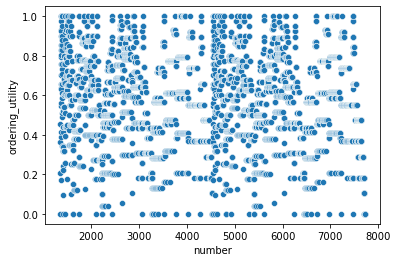

In [6]:
sns.scatterplot(x='number', y='ordering_utility', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='number', ylabel='sum_of_diff'>

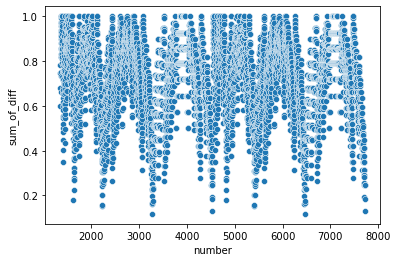

In [7]:
sns.scatterplot(x='number', y='sum_of_diff', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='ordering_utility', ylabel='sum_of_diff'>

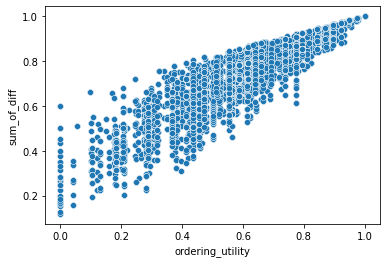

In [8]:
sns.scatterplot(x='ordering_utility', y='sum_of_diff', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='number', ylabel='rND'>

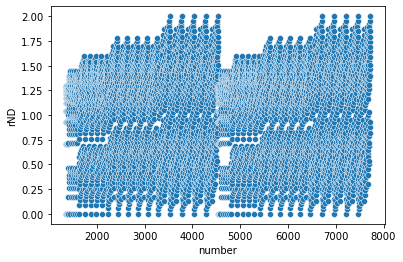

In [9]:
sns.scatterplot(x='number', y='rND', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='rND', ylabel='ordering_utility'>

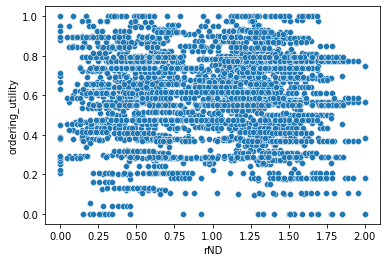

In [10]:
sns.scatterplot(x='rND', y='ordering_utility', data=df, legend=False, palette = 'muted')

In [11]:
# how many clusters should be reserved for 5:5 groups
clustersNoMaj = round(len(df.query('minSize == majSize and offset == 0').index) / len(df.index) * params['clusters'])
# make sure the other clusters can be split for male and female majorities
if ((params['clusters'] - clustersNoMaj) % 2 == 1):
    clustersNoMaj += 1
#clustersNoMaj
df.query('minSize == majSize and offset != 0')

,questionType,groupNames,colors,number,minSize,majSize,offset,majLabel,ordering_utility,sum_of_diff,rND,raw_rND,worst_rND
1925,ranking,"[Frauen, Männer]","[pink, teal]",3275,5,5,-20,male,0.000000,0.117647,0.149509,1.463312,1.720551
1926,ranking,"[Frauen, Männer]","[pink, teal]",3276,5,5,-20,male,0.000000,0.168067,0.212088,1.355643,1.720551
1927,ranking,"[Frauen, Männer]","[pink, teal]",3277,5,5,-20,male,0.130435,0.226891,0.308956,1.188977,1.720551
1928,ranking,"[Frauen, Männer]","[pink, teal]",3278,5,5,-20,male,0.282609,0.226891,0.492307,0.873512,1.720551
1929,ranking,"[Frauen, Männer]","[pink, teal]",3279,5,5,-20,male,0.282609,0.285714,1.073516,-0.126488,1.720551
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6365,ranking,"[Männer, Frauen]","[teal, pink]",7715,5,5,20,female,0.000000,0.284404,0.926484,0.126488,1.720551
6366,ranking,"[Männer, Frauen]","[teal, pink]",7716,5,5,20,female,0.000000,0.247706,1.507693,-0.873512,1.720551
6367,ranking,"[Männer, Frauen]","[teal, pink]",7717,5,5,20,female,0.000000,0.247706,1.691044,-1.188977,1.720551
6368,ranking,"[Männer, Frauen]","[teal, pink]",7718,5,5,20,female,0.000000,0.183486,1.787912,-1.355643,1.720551


In [12]:
clustersMaj = params['clusters'] - clustersNoMaj
attributes = ['rND','ordering_utility']

dfForClustering = df.copy()
scaler = StandardScaler()
dfForClustering[attributes] = scaler.fit_transform(dfForClustering[attributes])
imp = SimpleImputer(strategy='mean')
dfForClustering[attributes] = imp.fit_transform(dfForClustering[attributes])

dfFemale = dfForClustering.query("majLabel == 'female' and (minSize != majSize or offset !=0)")[attributes].copy()
clustering = AgglomerativeClustering(n_clusters = clustersMaj // 2, linkage='ward').fit(dfFemale)
dfFemale = df.query("majLabel == 'female' and (minSize != majSize or offset != 0)").copy()
dfFemale['cluster'] = clustering.labels_ + params['clusters_offset']

dfMale = dfForClustering.query("majLabel == 'male' and (minSize != majSize or offset != 0)")[attributes].copy()
clustering2 = AgglomerativeClustering(n_clusters = clustersMaj // 2, linkage='ward').fit(dfMale)
dfMale = df.query("majLabel == 'male' and (minSize != majSize or offset != 0)").copy()
dfMale['cluster'] = clustering2.labels_ + clustersMaj // 2 + params['clusters_offset']

dfTotal = dfFemale.append(dfMale)

dfNoMaj = dfForClustering.query("minSize == majSize and offset == 0")[attributes].copy()
clustering3 = AgglomerativeClustering(n_clusters = clustersNoMaj, linkage='ward').fit(dfNoMaj)
dfNoMaj = df.query("minSize == majSize and offset == 0").copy()
dfNoMaj['cluster'] = clustering3.labels_ + clustersMaj + params['clusters_offset']

dfClustered = dfTotal.append(dfNoMaj)
dfClustered

,questionType,groupNames,colors,number,minSize,majSize,offset,majLabel,ordering_utility,sum_of_diff,rND,raw_rND,worst_rND,cluster
3185,ranking,"[Männer, Frauen]","[teal, pink]",4535,1,9,-20,female,0.000000,0.600000,1.299277,-0.425449,1.421590,12
3186,ranking,"[Männer, Frauen]","[teal, pink]",4536,1,9,-20,female,0.204545,0.681818,0.000000,1.421590,1.421590,11
3187,ranking,"[Männer, Frauen]","[teal, pink]",4537,1,9,-20,female,0.363636,0.745455,0.703438,0.421590,1.421590,11
3188,ranking,"[Männer, Frauen]","[teal, pink]",4538,1,9,-20,female,0.454545,0.781818,0.925348,0.106125,1.421590,11
3189,ranking,"[Männer, Frauen]","[teal, pink]",4539,1,9,-20,female,0.545455,0.818182,1.042588,-0.060542,1.421590,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,ranking,"[Männer, Frauen]","[teal, pink]",7211,5,5,0,female,0.382353,0.708333,0.926484,0.126488,1.720551,19
5862,ranking,"[Männer, Frauen]","[teal, pink]",7212,5,5,0,female,0.382353,0.572917,1.507693,-0.873512,1.720551,19
5863,ranking,"[Männer, Frauen]","[teal, pink]",7213,5,5,0,female,0.382353,0.572917,1.691044,-1.188977,1.720551,19
5864,ranking,"[Männer, Frauen]","[teal, pink]",7214,5,5,0,female,0.205882,0.500000,1.787912,-1.355643,1.720551,19


<AxesSubplot:xlabel='ordering_utility', ylabel='rND'>

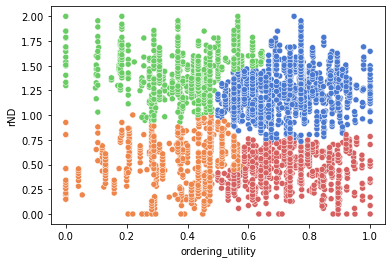

In [13]:
# clusters for majority female
sns.scatterplot(x='ordering_utility', y='rND', hue='cluster',
                data=dfClustered.query("majLabel == 'female' and (minSize != majSize or offset !=0)"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='ordering_utility', ylabel='rND'>

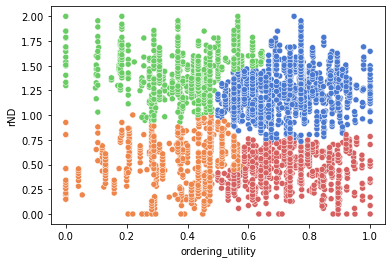

In [14]:
# clusters for majority male
sns.scatterplot(x='ordering_utility', y='rND', hue='cluster',
                data=dfClustered.query("majLabel == 'male' and (minSize != majSize or offset !=0)"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='ordering_utility', ylabel='rND'>

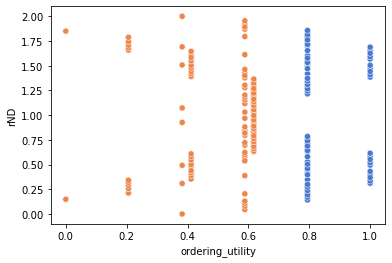

In [15]:
# clusters where there is no majority
sns.scatterplot(x='ordering_utility', y='rND', hue='cluster',
                data=dfClustered.query("majSize == minSize and offset == 0"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='ordering_utility', ylabel='rND'>

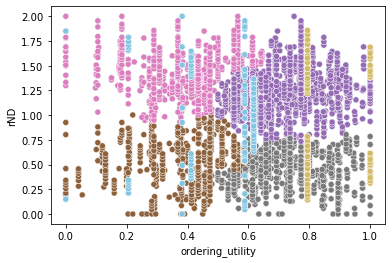

In [16]:
# all clusters
sns.scatterplot(x='ordering_utility', y='rND', hue='cluster', data=dfClustered, legend=False, palette = 'muted')

In [17]:
male = 0
female = 0
noMaj = 0
for i in range(len(questions)):
    if (questions[i]['majSize'] != questions[i]['minSize'] or questions[i]['offset']!=0):
        if (questions[i]['majLabel'] == 'female'):
            questions[i]['cluster'] = int(clustering.labels_[female]) + params['clusters_offset']
            female += 1
        else:
            questions[i]['cluster'] = int(clustering2.labels_[male]) + clustersMaj // 2 + params['clusters_offset']
            male += 1
    else:
        questions[i]['cluster'] = int(clustering3.labels_[noMaj]) + clustersMaj + params['clusters_offset']
        noMaj += 1
        
with open("ranking_questions2.json", "w") as write_file:
    json.dump(questions, write_file)

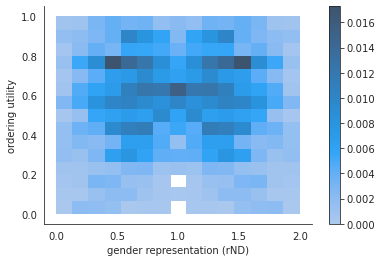

In [28]:
# add gender-focused version of the cv score (demographic parity)
# S=1 for male personas, S=0 for female personas
dfClustered['gender_rND'] = dfClustered['rND']
dfClustered.loc[df['majLabel']=='female', 'gender_rND'] = 2-dfClustered['rND']

sns.set_style("white")
ax = sns.histplot(data=dfClustered, x='gender_rND', y='ordering_utility', bins=15, cbar=True, stat='probability')
ax.set(ylabel='ordering utility', xlabel='gender representation (rND)')
sns.despine()